In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
# HS300 = list(ts.get_hs300s()['code'])
HS300_df = pd.read_csv('../database/HS300IDX_ALL.csv')
HS300 = list(set(HS300_df.con_code))
HS300 = [x.split('.')[0] for x in HS300]
ZZ500 = list(ts.get_zz500s()['code'])
SZ50 = list(ts.get_sz50s()['code'])
HSALL = list(set(ts.get_stock_basics().index) - set(['601162', '002940', '002939', '300674', '002941']))
# HSALL = HSALL + ['000866', '600001', '000956']

BENCHMARK = '399300'
TARGET = HS300
# TARGET = ['399300']
# BENCHMARK = '000905'
# TARGET = ['000905']
# TARGET = ZZ500
# BENCHMARK = '000016'
# TARGET = SZ50
# TARGET = HSALL
# BENCHMARK = 'NDX'
# TARGET = NASDAQ100
# BENCHMARK = 'BITCOIN'
# TARGET = CRYPTOCURRENCY
# BENCHMARK = 'EOS'
# TARGET = ['EOS']

ALL_TARGET = TARGET[:]
len(ALL_TARGET)

pd

d:\python36\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = False
spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()
timeframe = '10y'
ignore = True

for symbol in TARGET + [BENCHMARK]:
# for symbol in ['000016']:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # A股
    elif symbol in HS300 or symbol in ZZ500 or symbol in HSALL or symbol in FULL_SZ50:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)

        if symbol.startswith('00') or symbol.startswith('30'):
            temp_symbol = '%s.SZ' % symbol
        elif symbol.startswith('60'):
            temp_symbol = '%s.SH' % symbol
        df = pro.daily_basic(ts_code=temp_symbol, start_date='20050101', end=time.strftime('%Y%m%d'))
        datafile = '../database/market/%s_pro_daily_basic.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # NASDAQ
    elif symbol in NASDAQ100:
        datafile = None
        while datafile is None:
            try:
                datafile = spider_n.get_stock_data(symbol, timeframe)
            except:
                time.sleep(5)
    
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
#     print(datafile)
    time.sleep(1)

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2018-01-01'
end_date = '2018-11-01'
# end_date = time.strftime('%Y-%m-%d')

TURTLE_POS = 10
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 90
TURTLE_LONG_SELL_N = 30

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = False
IS_UNIQUE = False
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in TARGET + [BENCHMARK]:
# for symbol in ['600009']:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['pre_close'] = stock_df.close.shift(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.pre_close) / stock_df.pre_close
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
#     stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#     stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
#     stock_df['MA360'] = stock_df['open'].rolling(360).mean()
#     stock_df['MA250'] = stock_df['open'].rolling(250).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA90'] = stock_df['open'].rolling(90).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    stock_df['MA10'] = stock_df['open'].rolling(10).mean()
    
    df = '../database/market/%s_pro_daily_basic.csv' % symbol
    try:
        df = pd.read_csv(df)
        df = df[::-1]
        df = df.assign(trade_date=pd.to_datetime(df['trade_date'], format='%Y%m%d'))
        df.set_index(['trade_date'], inplace=True)
        df.index = df.index.to_period('D')
        stock_df = pd.concat([stock_df, df['pe']], axis=1)
    except:
        print(symbol)
        stock_df['pe'] = 9999
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df

601611
600638
600900
601021
600633
600072
600048
000413
600570
600057
601012
600977
600271
600033
000698
002049
002410
600508
601003
601369
600151
002028
000001
600602
600003
600578
600169
002110
600628
000667
002399
002074
600196
300433
600062
601117
601198
600868
600096
601288
600585
601299
600233
600805
600408
000061
601988
600060
600657
600307
601005
600312
300033
000806
000751
000900
000423
002202
300017
002572
601668
000829
002078
000157
600091
002152
002466
600867
002475
600884
600519
603858
000932
000333
002456
600481
600675
600138
000401
600881
000878
600376
002736
601801
600522
600121
000825
002174
603993
002608
600012
600652
600627
600018
600125
600277
600216
002841
000682
600219
000780
601018
002344
601555
601163
002415
300182
601899
600300
000725
600188
000822
000703
600007
600835
600340
002378
002925
002653
000406
000016
000533
600959
600346
600654
601992
601231
600259
600653
600581
002498
000807
600068
000883
600320
600205
601881
600398
000088
002083
000920
600123
000671

In [5]:
'''抽查数据'''

stock_df_dict[BENCHMARK].head(2)
stock_df_dict[BENCHMARK].tail(2)
# '000866' in HSALL
stock_df_dict['600009']
# pro.index_weight(index_code='399300.SZ', trade_date='', start_date='20150101', end_date='20150301')

# df = ts.get_k_data(code='601299', ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
# df
# stock_df_dict['601299'].head(2)

# df = stock_df_dict[BENCHMARK].iloc[:].copy()
# df.columns
# df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
# df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.set_index('date', inplace=True)
# ax = df.plot(kind='line', y='close', label='test', linewidth=1, grid=True)
# display_charts(df, chart_type='stock', kind='line', 
#                y=['open', 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N, 'MA30', 'MA60', 'MA180'], 
#                figsize=(900, 600))

'抽查数据'

,open,close,o_pct_chg,c_o_pct_chg,ROLLING_90_MAX,ROLLING_30_MIN,MA180,MA90,MA60,MA30,MA10,pe
date,,,,,,,,,,,,
2005-12-29,921.14,932.03,0.002274,0.000239,971.38,858.11,900.228556,904.796111,888.027833,887.838667,909.831,9999
2005-12-30,933.45,923.45,0.013364,0.001524,971.38,858.11,899.944056,904.966778,888.308833,890.201000,913.593,9999


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_90_MAX,ROLLING_30_MIN,MA180,MA90,MA60,MA30,MA10,pe
date,,,,,,,,,,,,
2018-10-19,3017.75,3134.95,-0.025838,-0.008751,3846.94,3017.75,3686.096444,3402.984889,3327.212500,3260.147333,3180.872,9999
2018-10-22,3159.56,3270.27,0.046992,0.007850,3819.45,3017.75,3679.861000,3395.347333,3322.764167,3254.353333,3160.672,9999


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_90_MAX,ROLLING_30_MIN,MA180,MA90,MA60,MA30,MA10,pe
date,,,,,,,,,,,,
2005-09-30,13.161,12.995,0.011451,0.003814,14.595,12.829,13.425111,13.519367,13.658067,13.355433,13.0805,9999
2005-10-10,13.004,12.929,-0.011929,0.000693,14.595,12.829,13.427589,13.529778,13.651033,13.339433,13.0383,9999
2005-10-11,12.929,12.937,-0.005767,0.000000,14.595,12.829,13.430428,13.537233,13.642750,13.320100,13.0052,9999
2005-10-12,12.954,12.763,0.001934,0.001314,14.595,12.829,13.432033,13.543133,13.629350,13.305200,12.9828,9999
2005-10-13,12.755,12.390,-0.015362,-0.000627,14.595,12.755,13.432806,13.551511,13.612783,13.282833,12.9571,9999
2005-10-14,12.423,12.266,-0.026029,0.002663,14.595,12.423,13.431006,13.565222,13.589717,13.253267,12.9065,9999
2005-10-17,12.183,12.059,-0.019319,-0.006767,14.595,12.183,13.427778,13.569178,13.563617,13.217367,12.8336,9999
2005-10-18,12.001,12.183,-0.014939,-0.004810,14.595,12.001,13.421939,13.563844,13.534617,13.171233,12.7251,9999
2005-10-19,12.183,12.208,0.015165,0.000000,14.595,12.001,13.417067,13.559244,13.508783,13.124533,12.6605,9999


In [6]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH'] = START_MONEY
show_df.loc[:, 'PROPERTY'] = START_MONEY

'用基准数据来存储策略数据'

In [7]:
%%time
# %xmode

'''简易海龟策略，唐安奇通道突破信号，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = True
IS_RANDOM_BUY = False
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0
# TARGET = []

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
    
    # 更新指数成分
    if BENCHMARK == '399300':
        NEW_TARGET_df = HS300_df[HS300_df.trade_date == int(today.strftime('%Y%m%d'))]
        if len(NEW_TARGET_df) != 0:
            NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
            if sorted(NEW_TARGET) != sorted(TARGET):
                print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
                TARGET = NEW_TARGET
        else:
            pass
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1 and symbol in HS300:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     try:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
#     except:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue

        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA180:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]

        # 突破上行趋势，就买一份
#         order_arr = order_df.to_records(index=False)
        is_buy = False
        if True:
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
#             tmp_list.append((return_lastyear, symbol))
            try:
                pe = stock_df_dict[symbol][:today].iloc[-1].pe
            except:
                pe = 9999
            tmp_list.append((pe, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         buy_list = [x[1] for x in tmp_list if x[0]>1]
        buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    order_arr = order_df.to_records(index=False)
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue

        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1 and symbol in HS300:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
    CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
    
#     print(today)


    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_TT'] = show_df['PROPERTY']

2017-01-01 2018-01-01 100000 100000 0.000
2018-01-02 CHANGE TARGET 300
2018-06-29 CHANGE TARGET 300
2018-01-01 2018-11-01 100000 101274 0.013
START_MONEY 100000
CASH 101282.49879225418
HAPPY_MONEY 0
PROPERTY 101282.49879225418
BENCHMARK 4045.21 3159.56 0.7810620462225694
Wall time: 7.68 s


In [8]:
order_df
ops_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2018-01-03,000425,2161,4.626,LONG,2018-02-08,4.319,EXIT,-663.427,90011.433178,100008.219178
1,2018-01-03,000671,1202,8.318,LONG,2018-02-09,7.436,EXIT,-1060.16,80013.197178,100008.219178
2,2018-01-03,001979,508,19.661,LONG,2018-03-23,20.167,EXIT,257.048,70025.409178,100008.219178
3,2018-01-03,002027,855,11.685,LONG,2018-02-09,10.859,EXIT,-706.23,60034.734178,100008.219178
4,2018-01-03,002202,524,19.050,LONG,2018-02-02,16.343,EXIT,-1418.47,50052.534178,100008.219178
5,2018-01-03,300251,924,10.821,LONG,2018-03-26,11.155,EXIT,308.616,40053.930178,100008.219178
6,2018-01-03,600028,1707,5.858,LONG,2018-06-12,6.181,EXIT,551.361,30054.324178,100008.219178
7,2018-01-03,600031,1077,9.284,LONG,2018-02-08,8.576,EXIT,-762.516,20055.456178,100008.219178
8,2018-01-03,600048,699,14.293,LONG,2018-02-12,13.788,EXIT,-352.995,10064.649178,100008.219178
9,2018-01-03,600188,648,15.414,LONG,2018-03-05,14.641,EXIT,-500.904,76.377178,100008.219178


,ops_date,ops,symbol,count,price,reason,profit
0,2018-01-03,BUY,000425,2161,4.626,LONG,0
1,2018-01-03,BUY,000671,1202,8.318,LONG,0
2,2018-01-03,BUY,001979,508,19.661,LONG,0
3,2018-01-03,BUY,002027,855,11.685,LONG,0
4,2018-01-03,BUY,002202,524,19.050,LONG,0
5,2018-01-03,BUY,300251,924,10.821,LONG,0
6,2018-01-03,BUY,600028,1707,5.858,LONG,0
7,2018-01-03,BUY,600031,1077,9.284,LONG,0
8,2018-01-03,BUY,600048,699,14.293,LONG,0
9,2018-01-03,BUY,600188,648,15.414,LONG,0


In [9]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / TURTLE_POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

START                2018-01-01
END                  2018-11-01
TURTLE_POS                   10
ROLLMAX                       0
ROLLMIN                       0
MA_SHORT                     60
MA_LONG                     180
X_DAY_RETURN                250
ORDER                        20
STOCK                        17
RETURN                0.0127417
MAXDROPDOWN           -0.156198
WINRATE                     0.4
annual_return         0.0165826
annual_volatility      0.236308
calmar_ratio           0.106164
sharpe_ratio           0.187676
alpha                  0.179561
beta                   0.451309
ALL_DAYS                    194
FREECASH_DAY                113
MISS_SIGNAL                 760
RET_PER_YEAR                   
dtype: object

In [10]:
%%time
# %xmode

'''均线突破策略，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = False
IS_RANDOM_BUY = False
IS_UNIQUE = False
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
        
    # 更新指数成分
    if BENCHMARK == '399300':
        NEW_TARGET_df = HS300_df[HS300_df.trade_date == int(today.strftime('%Y%m%d'))]
        if len(NEW_TARGET_df) != 0:
            NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
            if sorted(NEW_TARGET) != sorted(TARGET):
                print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
                TARGET = NEW_TARGET
        else:
            pass
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1 and symbol in HS300:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
#                 is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                is_sell = (today_market.MA10 <= today_market.MA60)
#                 is_sell = (today_market.MA180 <= today_market.MA250)
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     try:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
#     except:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue
        
        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
#             if benchmark_today_market.MA60 < benchmark_today_market.MA180:
            if benchmark_today_market.MA90 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA180 < benchmark_today_market.MA250:
#             if benchmark_today_market.MA180 < benchmark_today_market.MA360:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA250 and benchmark_today_market.MA180 < benchmark_today_market.MA250:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]
        yesterday_market = stock_df_dict[symbol].loc[:today].iloc[-2]

        # 突破上行趋势，就买一份
        is_buy = False
        if True:
#             if today_market.MA90 >= today_market.MA180 and yesterday_market.MA90 <= yesterday_market.MA180:
            if today_market.MA10 >= today_market.MA60:
#             if today_market.MA180 > today_market.MA250:
                is_buy = True
                buy_reason = 'LONG'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            lastyear_today = pd.to_datetime('%d-%d-01' % (today.year - 1, today.month))
            if len(stock_df_dict[symbol][lastyear_today:today]) < 100:
#                 print('%s %d 停牌' % (symbol, len(stock_df_dict[symbol][lastyear_today:today])))
#                 continue
                pass
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
            tmp_list.append((return_lastyear, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         print(today, tmp_list)
        buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    order_arr = order_df.to_records(index=False)
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue

        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1 and symbol in HS300:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
    CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
    
#     print(today)
    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_MA'] = show_df['PROPERTY']

2017-01-01 2018-01-01 100000 100000 0.000
2018-01-02 CHANGE TARGET 300
2018-06-29 CHANGE TARGET 300
2018-01-01 2018-11-01 100000 84513 -0.155
START_MONEY 100000
CASH 86442.52689274891
HAPPY_MONEY 0
PROPERTY 86442.52689274892
BENCHMARK 4045.21 3159.56 0.7810620462225694
Wall time: 41.4 s


In [11]:
order_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2018-01-03,603833,83,120.348,LONG,2018-04-03,136.827,EXIT,1367.76,90019.335178,100008.219178
1,2018-01-03,600038,213,46.832,LONG,2018-01-17,40.369,EXIT,-1376.62,80044.119178,100008.219178
2,2018-01-03,601117,1450,6.896,LONG,2018-02-26,6.808,EXIT,-127.6,70044.919178,100008.219178
3,2018-01-03,601021,263,37.999,LONG,2018-01-17,33.75,EXIT,-1117.49,60051.182178,100008.219178
4,2018-01-03,601333,1833,5.454,LONG,2018-02-05,4.806,EXIT,-1187.78,50054.000178,100008.219178
5,2018-01-03,600271,469,21.294,LONG,2018-01-24,20.763,EXIT,-249.039,40067.114178,100008.219178
6,2018-01-03,600115,1252,7.983,LONG,2018-02-27,8.033,EXIT,62.6,30072.398178,100008.219178
7,2018-01-03,002624,302,33.051,LONG,2018-01-10,31.448,EXIT,-484.106,20090.996178,100008.219178
8,2018-01-03,300251,924,10.821,LONG,2018-04-13,11.391,EXIT,526.68,10092.392178,100008.219178
9,2018-01-03,300072,363,27.522,LONG,2018-02-12,24.114,EXIT,-1237.1,101.906178,100008.219178


In [12]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / TURTLE_POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

START                2018-01-01
END                  2018-11-01
TURTLE_POS                   10
ROLLMAX                       0
ROLLMIN                       0
MA_SHORT                     60
MA_LONG                     180
X_DAY_RETURN                250
ORDER                        75
STOCK                        49
RETURN                -0.135646
MAXDROPDOWN           -0.202272
WINRATE                0.324324
annual_return         -0.172507
annual_volatility       0.26655
calmar_ratio          -0.852844
sharpe_ratio          -0.581097
alpha                  0.100424
beta                   0.852192
ALL_DAYS                    194
FREECASH_DAY                  1
MISS_SIGNAL                9986
RET_PER_YEAR                   
dtype: object

In [13]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)
len(df)

'计算标的持有、收益等'

,pro_pct
symbol,
300144,0.990657
002841,0.223502
603833,0.136928
600085,0.120244
601288,0.116814


,pro_pct
symbol,
600011,-0.244324
601808,-0.244659
600739,-0.263645
600660,-0.285473
600518,-0.343186


49

In [14]:
# symbol = BENCHMARK
# symbol = '002252'
# symbol_list = ['601360', '601888']
# symbol_list = []

# for symbol in symbol_list:
#     df = stock_df_dict[symbol]['20140101':end_date].copy()
#     df.reset_index(drop=False, inplace=True)
#     df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
#     df.set_index(keys=['date'], inplace=True)
#     display_charts(df, chart_type='default', title='%s' % symbol, y=['open', 'MA90', 'MA180'], figsize=(900, 300))

# pd.set_option('display.max_rows', None)
# df = order_df.copy()
# df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# # df
# # df[df.symbol == symbol]

# df = ops_df.copy()
# # df
# # df[df.symbol == symbol]

# pd.reset_option("display.max_rows")

In [15]:
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [15, 5]

# symbol = '002624'

# df = order_df.copy()

# df = ops_df.copy()
# # df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df = df[df.symbol == symbol]
# df
# df.profit.sum()

# symbol_df = stock_df_dict[symbol].copy()
# symbol_df = symbol_df.loc[:, ['open', 'MA90', 'MA180']]
# ax = symbol_df.plot(kind='line',title=symbol, linewidth=0.7, grid=True)

# scatter_df = df[df.ops == 'BUY']
# plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='BLUE', alpha=0.5)
# scatter_df = df[df.ops == 'SELL']
# plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='RED', alpha=0.5)

# symbol_df.reset_index(drop=False, inplace=True)
# symbol_df['date'] = symbol_df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# symbol_df.set_index(keys=['date'], inplace=True)
# display_charts(symbol_df, chart_type='stock', y=['open', 'MA90', 'MA180'], figsize=(900, 600))

# stock_df_dict['600372']

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_90_MAX',
       'ROLLING_30_MIN', 'MA180', 'MA90', 'MA60', 'MA30', 'MA10', 'pe', 'CASH',
       'PROPERTY_TT', 'PROPERTY_MA'],
      dtype='object')

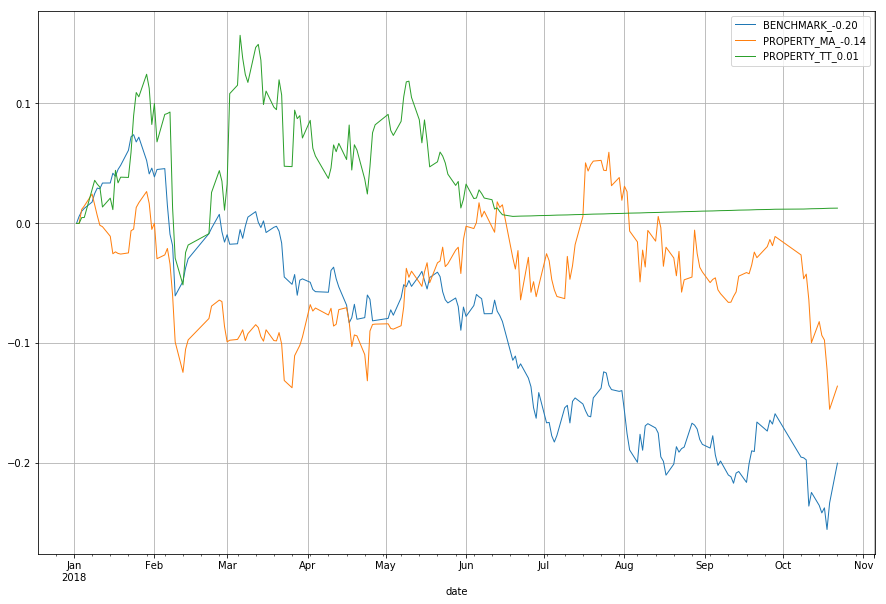

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
# for col in sorted(df.columns):
#     if 'PROPERTY' in col:
#         df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
#         ax = df.plot(kind='line', y=col, secondary_y=False, label='MA_%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [17]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
# df.drop(columns=['PROPERTY_TT'], inplace=True)
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)
#     if 'CASH' in col:
#         df[col] = df[col] / df.iloc[0][col]
#         show_columns.append(col)
        
# df['unused'] = df['CASH'] / df['PROPERTY_TT']
# df = df.loc['20070101':]
# show_columns = ['unused']
# show_columns.append('unused')

df = df.loc[:, show_columns]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

# display_charts(df, chart_type='stock', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_90_MAX',
       'ROLLING_30_MIN', 'MA180', 'MA90', 'MA60', 'MA30', 'MA10', 'pe', 'CASH',
       'PROPERTY_TT', 'PROPERTY_MA'],
      dtype='object')

In [20]:
symbol = '399300'
df = stock_df_dict[symbol].copy()
df = df.loc[start_date:end_date]
# df = df.loc[:, show_columns]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.dtypes
df.set_index(keys=['date'], inplace=True)

display_charts(df, chart_type='stock', y=['open'], figsize=(900, 400))

date              datetime64[ns]
open                     float64
close                    float64
o_pct_chg                float64
c_o_pct_chg              float64
ROLLING_90_MAX           float64
ROLLING_30_MIN           float64
MA180                    float64
MA90                     float64
MA60                     float64
MA30                     float64
MA10                     float64
pe                         int64
dtype: object

In [19]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
df['h_days'] = (df.sell_date - df.buy_date)
df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df = df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='pro_pct', ascending=False).head(5)
# df.sort_values(by='pro_pct', ascending=False).tail(5)
len(df)

temp_df = df.copy()
symbol_list = list(temp_df.index)
# symbol_list = list(reversed(symbol_list))
# for symbol in symbol_list[:3] + symbol_list[:1]:
for symbol in symbol_list[:]:
    symbol_df = stock_df_dict[symbol].copy()
    symbol_df = symbol_df.loc[start_date:, ['open', 'MA10', 'MA60']]
    symbol_df = symbol_df.iloc[2000:]
    ax = symbol_df.plot(kind='line', title='%s %.2f' % (symbol, temp_df.loc[symbol].pro_pct), linewidth=0.7, grid=True)
#     df = ops_df.copy()
#     df = df[df.symbol == symbol]
#     scatter_df = df[df.ops == 'BUY']
#     plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='BLUE', alpha=0.9)
#     scatter_df = df[df.ops == 'SELL']
#     plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='RED', alpha=0.9)

49

TypeError: Empty 'DataFrame': no numeric data to plot